## Gaussian Mixture Models

In [142]:
# %load std_ipython_import.txt
import pandas as pd
import scipy as spy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import scale
from sklearn.mixture import GMM, DPGMM, VBGMM
from sklearn.neighbors import KernelDensity

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

#### Examples from <i>Elements of Statistical Learning</i> by Hastie et al. (2009)
#### Section 6.8

In [4]:
data = pd.read_csv('data/SAheart.data', sep=',', decimal='.', usecols=np.arange(1,11))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 461
Data columns (total 10 columns):
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 37.9+ KB


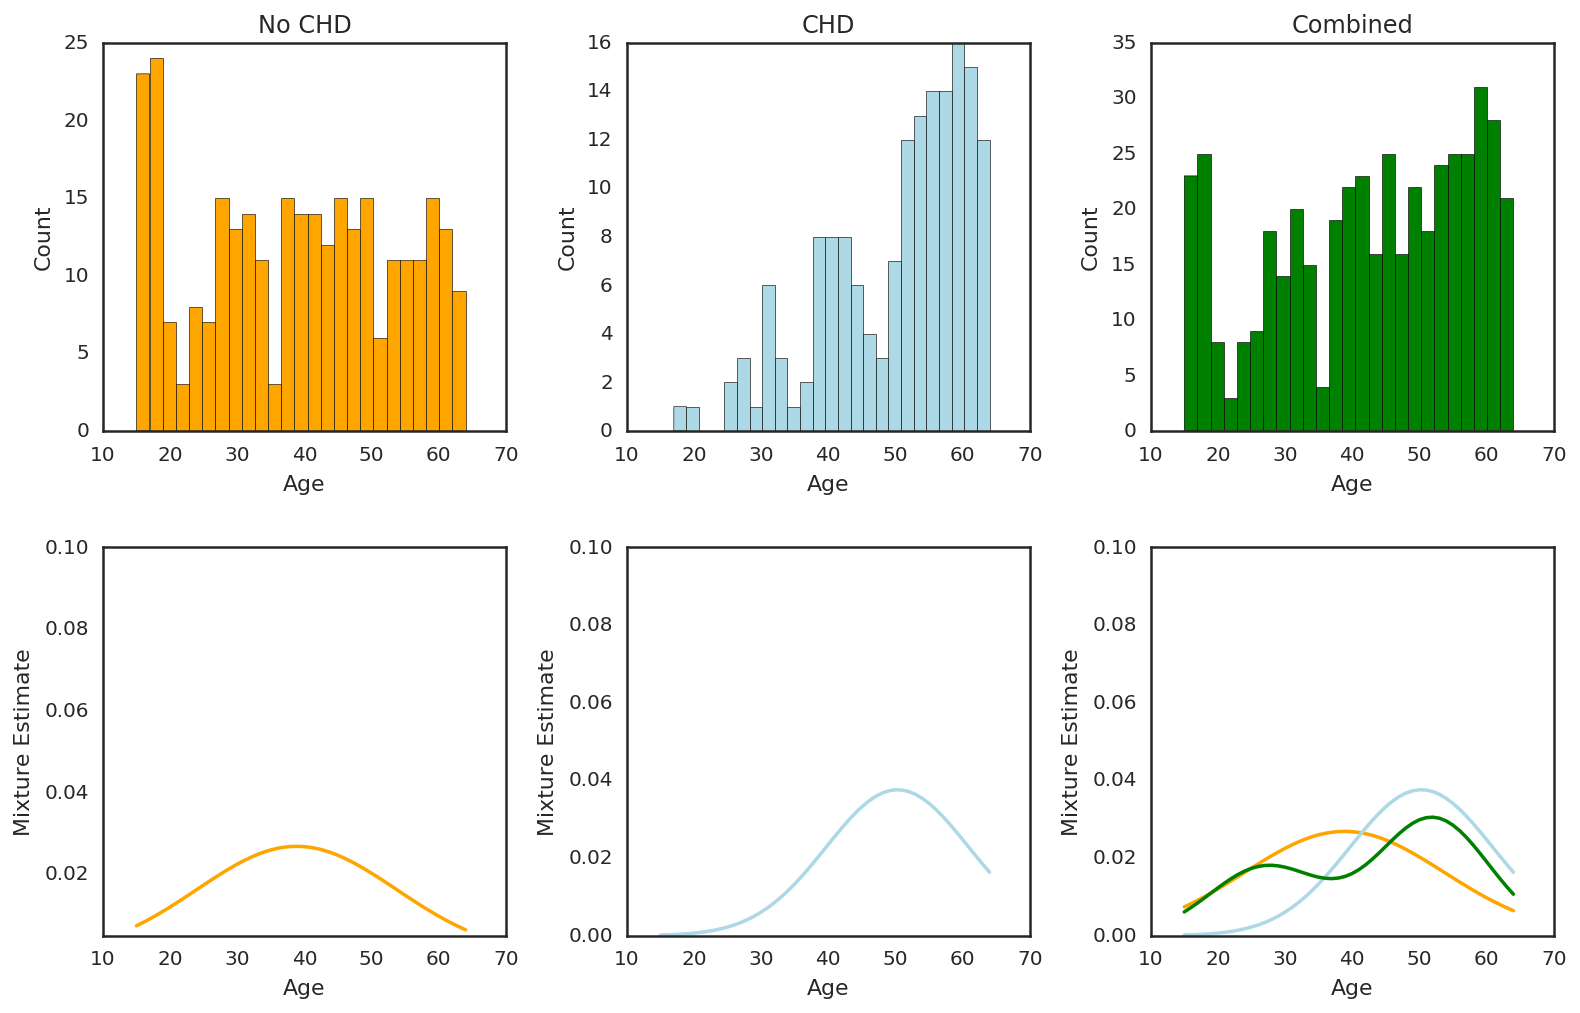

In [94]:
mixm = GMM(n_components=1, covariance_type='tied')
x = np.linspace(data.age.min(), data.age.max()).reshape(-1,1)

mixm.fit(data[data['chd'] == 0]['age'].reshape(-1,1))
no_chd = np.exp(mixm.score(x))

mixm.fit(data[data['chd'] == 1]['age'].reshape(-1,1))
chd = np.exp(mixm.score(x))

mixm.set_params(n_components=2)
mixm.fit(data['age'].reshape(-1,1))
combined = np.exp(mixm.score(x))

# Create Plots
fig, ax = plt.subplots(2,3, figsize=(13,8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Plots on first row
ax[0,0].hist(data[data.chd == 0]['age'].values, bins=25, color='orange')
ax[0,0].set_title('No CHD')

ax[0,1].hist(data[data.chd == 1]['age'].values, bins=25, color='lightblue')
ax[0,1].set_title('CHD')

ax[0,2].hist(data.age.values, bins=25, color='g')
ax[0,2].set_title('Combined')

for i in ax[0]:
    i.set_xlabel('Age')
    i.set_ylabel('Count')

# Plots on second row
ax[1,0].plot(x, no_chd, c='orange')

ax[1,1].plot(x, chd, c='lightblue')

ax[1,2].plot(x, no_chd, c='orange')
ax[1,2].plot(x, chd, c='lightblue')
ax[1,2].plot(x, combined , c='green')

for i in ax[1]:
    i.set_ylim(ymax = 0.10)
    i.set_xlabel('Age')
    i.set_ylabel('Mixture Estimate')

#### section 8.5

In [169]:
y = np.array([-0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53,
             0.06, 0.48, 1.01, 1.68, 1.80, 3.25, 4.12, 4.60, 5.28, 6.22]).reshape(-1,1)
mixm = GMM(n_components=2, verbose=1)
mixm.fit(y)

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
	EM iteration 3
	EM iteration 4
	EM iteration 5
	EM iteration 6
	EM iteration 7
	EM iteration 8
	EM iteration 9
		EM algorithm converged.


GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  tol=0.001, verbose=1)

In [193]:
mixm.means_

array([[ 1.05928087],
       [ 4.62201285]])

In [194]:
mixm.covars_

array([[ 0.77854847],
       [ 0.87684948]])

In [195]:
mixm.weights_

array([ 0.54663468,  0.45336532])

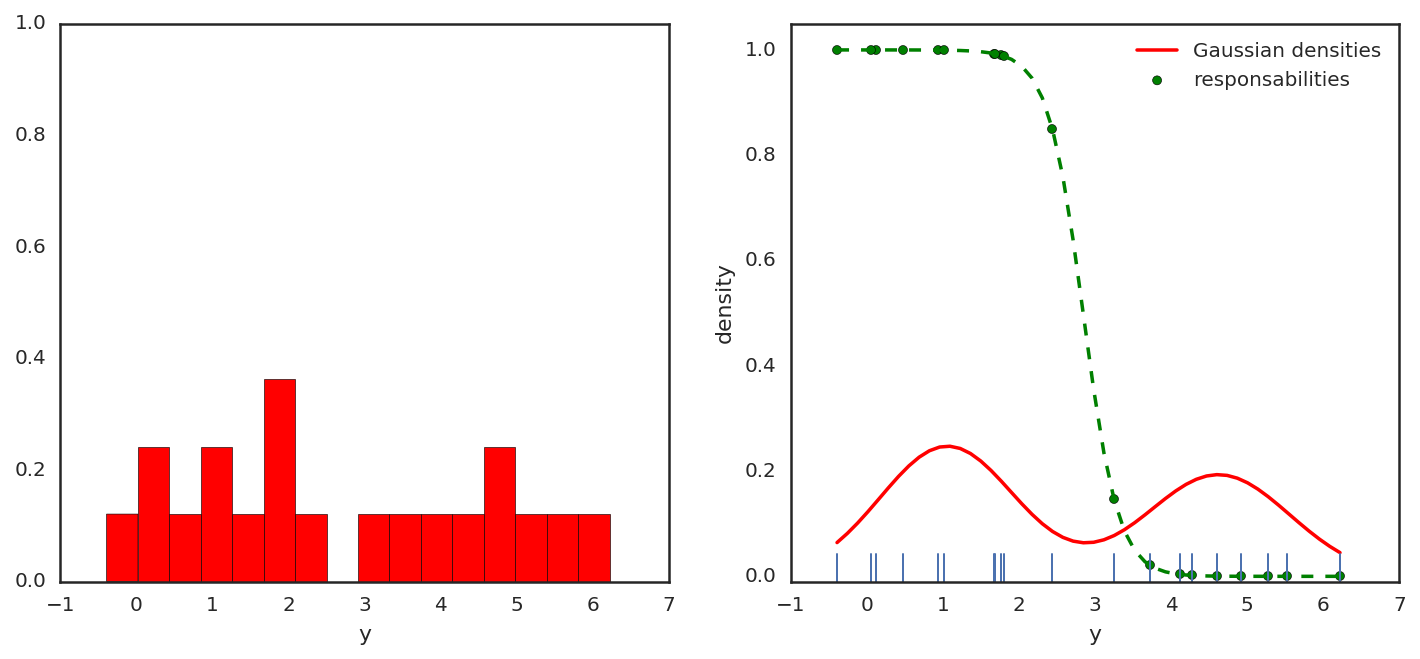

In [219]:
y_ = np.linspace(y.min(), y.max()).reshape(-1,1)
y_density = np.exp(mixm.score(y_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# left plot
ax1.hist(y, bins=16, normed=True, color='r')
ax1.set_ylim((0,1))

# right plot
ax2.plot(y_, y_density, color='r', label='Gaussian densities')
ax2.scatter(y, mixm.score_samples(y)[1][:,0], c='g', label='responsabilities')
ax2.plot(y_, mixm.score_samples(y_)[1][:,0], '--g' )
sns.distplot(y, hist=False, kde=False, rug=True, ax=ax2)
ax2.set_ylabel('density')
ax2.set_ylim((-0.01,1.05))
ax2.legend()

for i in fig.axes:
    i.set_xlabel('y')    

#### Example from <i>Pattern Recognition and Machine Learning</i> by Bishop (2006)
#### Section ?

In [10]:
faithful = pd.read_csv('data/faithful.csv')
faithful.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 271
Data columns (total 2 columns):
eruptions    272 non-null float64
waiting      272 non-null int64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


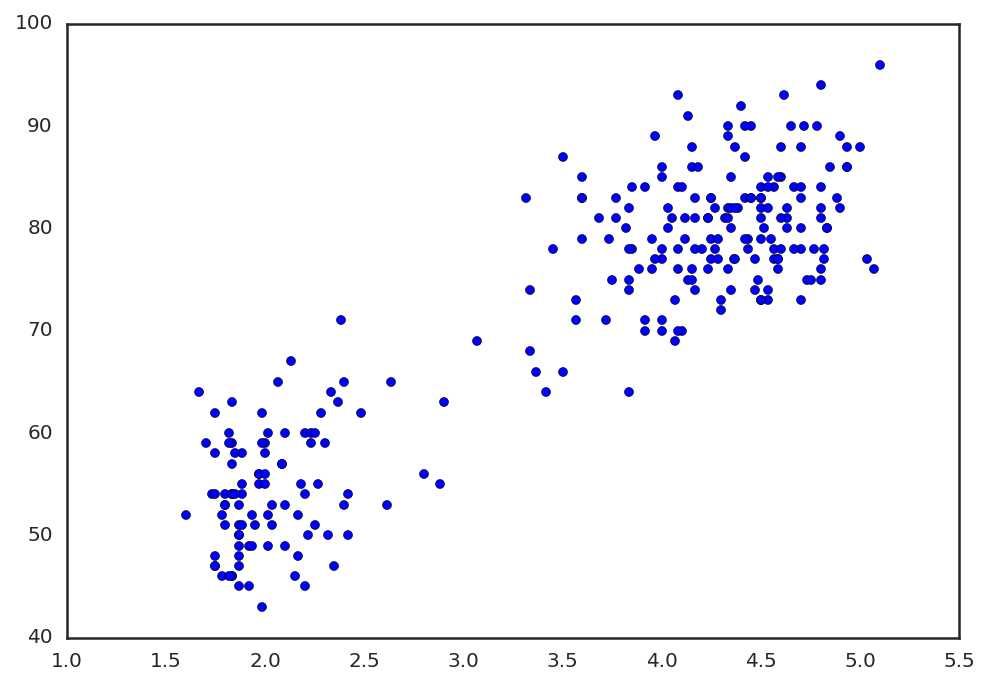

In [14]:
plt.scatter(faithful.eruptions, faithful.waiting)

In [34]:
mixm2 = GMM(n_components=2)
mixm2.fit(faithful)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  tol=0.001, verbose=0)

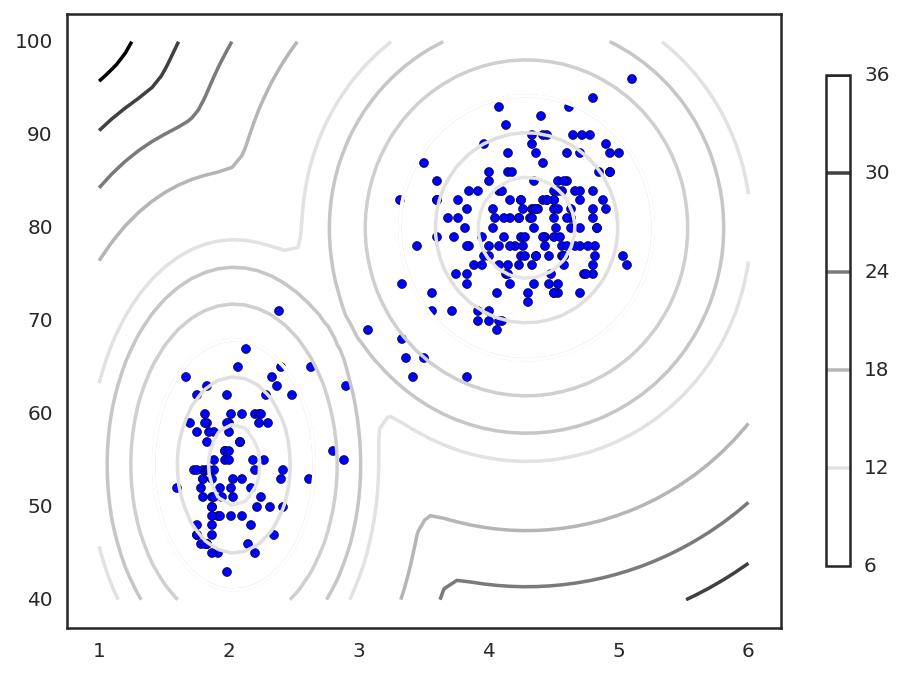

In [144]:
from matplotlib.colors import LogNorm

x = np.linspace(1, 6)
y = np.linspace(40, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -mixm2.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 1, 10))

CS = plt.contour(X, Y, Z)

CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(faithful.eruptions, faithful.waiting)
